# Mexican Sign Language recognition using hand-landmarking and a KNN algorithm

In [1]:
### SETUP
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set(style='white', context='notebook', rc={'figure.figsize':(20,12)})

top_dir = '/Users/diego/projects/itesoS3/machine-learning/machine-learning-s3'
NUM_CLASSES = 'two-classes'
ph1_labels_path = top_dir+f'/data/processed/ph1/{NUM_CLASSES}/ph1_data.csv'
ph2_labels_path = top_dir+f"/data/processed/ph2/{NUM_CLASSES}/ph2_parquet_files"
ph3_labels_path = top_dir+f"/data/processed/ph3/{NUM_CLASSES}"
n_candidates = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 21, 24, 30]


## Data Loading

### First we load the datasets that we preprocessed in the other notebooks
We will work on the data that we got after every stage of preprocessing
- Phase 1 data: extract landmarks from images
- Phase 2 data: transform landmarks
- Phase 3 data: selecting meaningful data using:
    - PCA
    - t-SNE
    - UMAP

### Phase 1 data

In [2]:
ph1_data = pd.read_csv(ph1_labels_path)
ph1_data

,class,person_id,cycle_id,handedness,frame_id,0x,0y,0z,1x,1y,...,18x,18y,18z,19x,19y,19z,20x,20y,20z,class_numeric
0,a,10,5,1,18,0.698705,0.597708,5.430746e-08,0.689057,0.594019,...,0.724514,0.636767,-0.022063,0.725913,0.648825,-0.023799,0.726151,0.660672,-0.025273,0
1,a,10,5,1,19,0.696072,0.552498,8.747327e-08,0.687571,0.553391,...,0.726976,0.587008,-0.027625,0.728233,0.597864,-0.029462,0.728701,0.608494,-0.030972,0
2,a,10,5,1,20,0.687384,0.534035,4.023701e-08,0.679920,0.529112,...,0.725282,0.535911,-0.024968,0.727159,0.546496,-0.027347,0.728042,0.557765,-0.028992,0
3,a,10,5,1,21,0.685077,0.511704,-6.767852e-09,0.675841,0.501121,...,0.723688,0.491881,-0.021968,0.725774,0.499097,-0.023825,0.726232,0.508896,-0.024676,0
4,a,10,5,1,22,0.406894,0.738662,-2.468195e-08,0.422051,0.735371,...,0.396595,0.795609,-0.032606,0.396789,0.810469,-0.037317,0.399019,0.824253,-0.040754,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,a,7,2,1,26,0.632380,0.329216,-1.219485e-07,0.613746,0.302716,...,0.644664,0.263879,-0.014295,0.638655,0.279247,-0.010199,0.641483,0.281104,-0.007430,0
3231,a,7,2,1,27,0.631766,0.328700,-1.220254e-07,0.613227,0.301339,...,0.643468,0.262964,-0.014483,0.637426,0.279056,-0.010260,0.640384,0.281678,-0.007365,0
3232,a,7,2,1,28,0.631074,0.329004,-1.307175e-07,0.613051,0.302196,...,0.642715,0.263598,-0.015192,0.637008,0.279575,-0.010814,0.640144,0.282083,-0.007652,0
3233,a,7,2,1,29,0.631041,0.328412,-1.369683e-07,0.613058,0.302000,...,0.643571,0.263576,-0.015804,0.637835,0.279348,-0.011336,0.640744,0.282566,-0.007934,0


#### Then we separate the features and targets into X and y

In [3]:
label_column = 'class_numeric'
ph1_id_col_names = [ 'class', 'person_id', 'cycle_id', 'handedness', 'frame_id']

ph1_landmark_col_names = []
for i in range(21):
    ph1_landmark_col_names.append(str(i)+"x")
    ph1_landmark_col_names.append(str(i)+"y")
    ph1_landmark_col_names.append(str(i)+"z")

ph1_X = ph1_data[ph1_landmark_col_names]
ph1_y = ph1_data[label_column]

ph1_X

,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,...,17z,18x,18y,18z,19x,19y,19z,20x,20y,20z
0,0.698705,0.597708,5.430746e-08,0.689057,0.594019,-0.012703,0.683772,0.599988,-0.022209,0.679746,...,-0.017737,0.724514,0.636767,-0.022063,0.725913,0.648825,-0.023799,0.726151,0.660672,-0.025273
1,0.696072,0.552498,8.747327e-08,0.687571,0.553391,-0.014968,0.681901,0.556796,-0.026703,0.678961,...,-0.022254,0.726976,0.587008,-0.027625,0.728233,0.597864,-0.029462,0.728701,0.608494,-0.030972
2,0.687384,0.534035,4.023701e-08,0.679920,0.529112,-0.011461,0.675146,0.525496,-0.021244,0.676088,...,-0.019275,0.725282,0.535911,-0.024968,0.727159,0.546496,-0.027347,0.728042,0.557765,-0.028992
3,0.685077,0.511704,-6.767852e-09,0.675841,0.501121,-0.009703,0.671222,0.492348,-0.017982,0.671220,...,-0.016895,0.723688,0.491881,-0.021968,0.725774,0.499097,-0.023825,0.726232,0.508896,-0.024676
4,0.406894,0.738662,-2.468195e-08,0.422051,0.735371,-0.009004,0.434508,0.744307,-0.016692,0.441471,...,-0.024190,0.396595,0.795609,-0.032606,0.396789,0.810469,-0.037317,0.399019,0.824253,-0.040754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,0.632380,0.329216,-1.219485e-07,0.613746,0.302716,-0.007097,0.600787,0.275640,-0.012958,0.589589,...,-0.012925,0.644664,0.263879,-0.014295,0.638655,0.279247,-0.010199,0.641483,0.281104,-0.007430
3231,0.631766,0.328700,-1.220254e-07,0.613227,0.301339,-0.006952,0.600276,0.273953,-0.012769,0.589101,...,-0.013094,0.643468,0.262964,-0.014483,0.637426,0.279056,-0.010260,0.640384,0.281678,-0.007365
3232,0.631074,0.329004,-1.307175e-07,0.613051,0.302196,-0.006382,0.600453,0.274484,-0.012029,0.589149,...,-0.013774,0.642715,0.263598,-0.015192,0.637008,0.279575,-0.010814,0.640144,0.282083,-0.007652
3233,0.631041,0.328412,-1.369683e-07,0.613058,0.302000,-0.006085,0.600702,0.273886,-0.011515,0.589593,...,-0.014094,0.643571,0.263576,-0.015804,0.637835,0.279348,-0.011336,0.640744,0.282566,-0.007934


#### Then we separate our data into training/testing sets

In [4]:
ph1_X_train, ph1_X_test, ph1_y_train, ph1_y_test = train_test_split(ph1_X, ph1_y, test_size=0.2, random_state=42)
ph1_X_train.shape

(2588, 63)

### Phase 2 data

In [5]:
# We wrote the data out as parquet files. Let's read them with the use of the pandas library
ph2_data = pd.read_parquet(ph2_labels_path, engine='fastparquet')
ph2_data

,class_numeric,b0x,b0y,b0z,b1x,b1y,b1z,b2x,b2y,b2z,...,v3x,v3y,v3z,mean_x,mean_y,mean_z,person_id,cycle_id,handedness,class
0,0,0.0,-0.0,0.0,-0.019333,-0.012600,0.001643,-0.033223,-0.017726,0.002217,...,0.678694,0.061572,-4.501155,0.344618,0.425332,-0.004384,1,1,0,a
1,0,0.0,-0.0,0.0,-0.018443,-0.012613,0.001769,-0.032238,-0.018307,0.002482,...,0.725780,0.076442,-4.461409,0.344739,0.425745,-0.004810,1,1,0,a
2,0,0.0,-0.0,0.0,-0.020611,-0.011262,0.001664,-0.034579,-0.015002,0.002388,...,0.743553,0.105389,-4.522160,0.344379,0.426648,-0.004969,1,1,0,a
3,0,0.0,-0.0,0.0,-0.020891,-0.009801,0.001665,-0.034945,-0.012790,0.002397,...,0.875916,0.092794,-4.579864,0.343865,0.427672,-0.005253,1,1,0,a
4,0,0.0,-0.0,0.0,-0.020598,-0.010223,0.001704,-0.034461,-0.013555,0.002565,...,0.660163,0.162474,-4.582228,0.343801,0.428773,-0.006244,1,1,0,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,1,0.0,0.0,-0.0,-0.003442,-0.019166,0.000959,-0.007385,-0.037069,0.001747,...,-2.268285,1.408503,-12.713003,0.558141,0.287725,-0.014315,9,5,1,b
3231,1,0.0,0.0,-0.0,-0.000505,-0.024086,0.000136,-0.001062,-0.046572,0.000236,...,-14.122936,8.011014,-91.433417,0.557461,0.290157,-0.012749,9,5,1,b
3232,1,0.0,0.0,-0.0,-0.000342,-0.023535,0.000092,-0.000715,-0.044835,0.000160,...,-26.963155,10.592418,-129.377976,0.556638,0.290610,-0.011686,9,5,1,b
3233,1,0.0,0.0,-0.0,-0.000904,-0.023424,0.000250,-0.001879,-0.044744,0.000435,...,-9.208885,4.368271,-49.184478,0.555815,0.289345,-0.012666,9,5,1,b


#### Then we separate the features and targets into X and y

In [6]:
label_column = 'class_numeric'
ph2_id_col_names = [ 'class', 'person_id', 'cycle_id', 'handedness']

ph2_landmark_col_names = []
for i in range(21):
    ph2_landmark_col_names.append("b"+str(i)+"x")
    ph2_landmark_col_names.append("b"+str(i)+"y")
    ph2_landmark_col_names.append("b"+str(i)+"z")

ph2_normal_vector_columns = ['v3x', 'v3y', 'v3z']
ph2_center_of_gravity_columns = ['mean_x', 'mean_y', 'mean_z']


ph2_X = ph2_data[ph2_landmark_col_names + ph2_normal_vector_columns + ph2_center_of_gravity_columns]
ph2_y = ph2_data[label_column]

ph2_X

,b0x,b0y,b0z,b1x,b1y,b1z,b2x,b2y,b2z,b3x,...,b19z,b20x,b20y,b20z,v3x,v3y,v3z,mean_x,mean_y,mean_z
0,0.0,-0.0,0.0,-0.019333,-0.012600,0.001643,-0.033223,-0.017726,0.002217,-0.042433,...,0.000601,0.002759,0.017125,-0.000312,0.678694,0.061572,-4.501155,0.344618,0.425332,-0.004384
1,0.0,-0.0,0.0,-0.018443,-0.012613,0.001769,-0.032238,-0.018307,0.002482,-0.041192,...,0.000750,0.002774,0.017552,-0.000187,0.725780,0.076442,-4.461409,0.344739,0.425745,-0.004810
2,0.0,-0.0,0.0,-0.020611,-0.011262,0.001664,-0.034579,-0.015002,0.002388,-0.043640,...,0.000889,0.004739,0.017041,-0.000059,0.743553,0.105389,-4.522160,0.344379,0.426648,-0.004969
3,0.0,-0.0,0.0,-0.020891,-0.009801,0.001665,-0.034945,-0.012790,0.002397,-0.044033,...,0.000838,0.006478,0.016817,-0.000142,0.875916,0.092794,-4.579864,0.343865,0.427672,-0.005253
4,0.0,-0.0,0.0,-0.020598,-0.010223,0.001704,-0.034461,-0.013555,0.002565,-0.043587,...,0.001192,0.005722,0.016659,0.000226,0.660163,0.162474,-4.582228,0.343801,0.428773,-0.006244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,0.0,0.0,-0.0,-0.003442,-0.019166,0.000959,-0.007385,-0.037069,0.001747,-0.008382,...,0.002367,-0.005164,0.013127,0.002653,-2.268285,1.408503,-12.713003,0.558141,0.287725,-0.014315
3231,0.0,0.0,-0.0,-0.000505,-0.024086,0.000136,-0.001062,-0.046572,0.000236,-0.001230,...,0.000292,-0.000869,0.003651,0.000330,-14.122936,8.011014,-91.433417,0.557461,0.290157,-0.012749
3232,0.0,0.0,-0.0,-0.000342,-0.023535,0.000092,-0.000715,-0.044835,0.000160,-0.000830,...,0.000204,-0.000605,0.004911,0.000234,-26.963155,10.592418,-129.377976,0.556638,0.290610,-0.011686
3233,0.0,0.0,-0.0,-0.000904,-0.023424,0.000250,-0.001879,-0.044744,0.000435,-0.002155,...,0.000564,-0.001559,0.006054,0.000643,-9.208885,4.368271,-49.184478,0.555815,0.289345,-0.012666


#### Then we separate our data into training/testing sets

In [7]:
ph2_X_train, ph2_X_test, ph2_y_train, ph2_y_test = train_test_split(ph2_X, ph2_y, test_size=0.2, random_state=42)
ph2_X_train.shape

(2588, 69)

### Phase 3 data

#### Cosine kernel PCA reduced data

In [8]:
label_column = 'class_numeric'


cos_pca_X_train_list = []
cos_pca_y_train_list = []
cos_pca_X_test_list = []
cos_pca_y_test_list = []

for n in n_candidates:
    this_data = pd.read_csv(ph3_labels_path+f'/cos_pca_{n}_reduced.csv')
    
    this_feature_col_names = []
    for i in range(n):
        this_feature_col_names.append(str(i))
    
    this_X = this_data[this_feature_col_names]
    this_y = this_data[label_column]

    this_X_train, this_X_test, this_y_train, this_y_test = train_test_split(this_X, this_y, test_size=0.2, random_state=42)


    cos_pca_X_train_list.append(this_X_train)
    cos_pca_y_train_list.append(this_y_train)
    cos_pca_X_test_list.append(this_X_test)
    cos_pca_y_test_list.append(this_y_test)

## K nearest neighbors
We only have one hyperparameter for this model: k, the number of neighbors to be considered when "voting" on the class of a sample.

Therefore, it seems like overkill to use gridsearch and we will just try out a bunch of values of k and choose whichever offers the best accuracy.

In [9]:
ph1_accuracy_scores = []
ph2_accuracy_scores = []
cos_pca_accuracy_scores = []
cos_pca_knn_list = []

for k in range(1, 128):
    ### PHASE 1 ###
    ph1_knn = KNeighborsClassifier(n_neighbors = k)
    ph1_knn.fit(ph1_X_train, ph1_y_train)
    ph1_y_pred = ph1_knn.predict(ph1_X_test)
    ph1_accuracy_scores.append(accuracy_score(ph1_y_test, ph1_y_pred))

    ### PHASE 2 ###
    ph2_knn = KNeighborsClassifier(n_neighbors = k)
    ph2_knn.fit(ph2_X_train, ph2_y_train)
    ph2_y_pred = ph2_knn.predict(ph2_X_test)
    ph2_accuracy_scores.append(accuracy_score(ph2_y_test, ph2_y_pred))

    ### PHASE 3 ###
    # Cosine Kernel PCA
    this_accuracy_scores_for_this_k = []
    this_cos_pca_knn_list_for_this_k = []
    for index, n in enumerate(n_candidates):
        this_knn = KNeighborsClassifier(n_neighbors = k)
        this_knn.fit(cos_pca_X_train_list[index], cos_pca_y_train_list[index])
        this_y_pred = this_knn.predict(cos_pca_X_test_list[index])
        
        this_accuracy_scores_for_this_k.append(accuracy_score(cos_pca_y_test_list[index], this_y_pred))
        this_cos_pca_knn_list_for_this_k.append(this_knn)

    cos_pca_accuracy_scores.append(this_accuracy_scores_for_this_k)
    cos_pca_knn_list.append(this_cos_pca_knn_list_for_this_k)

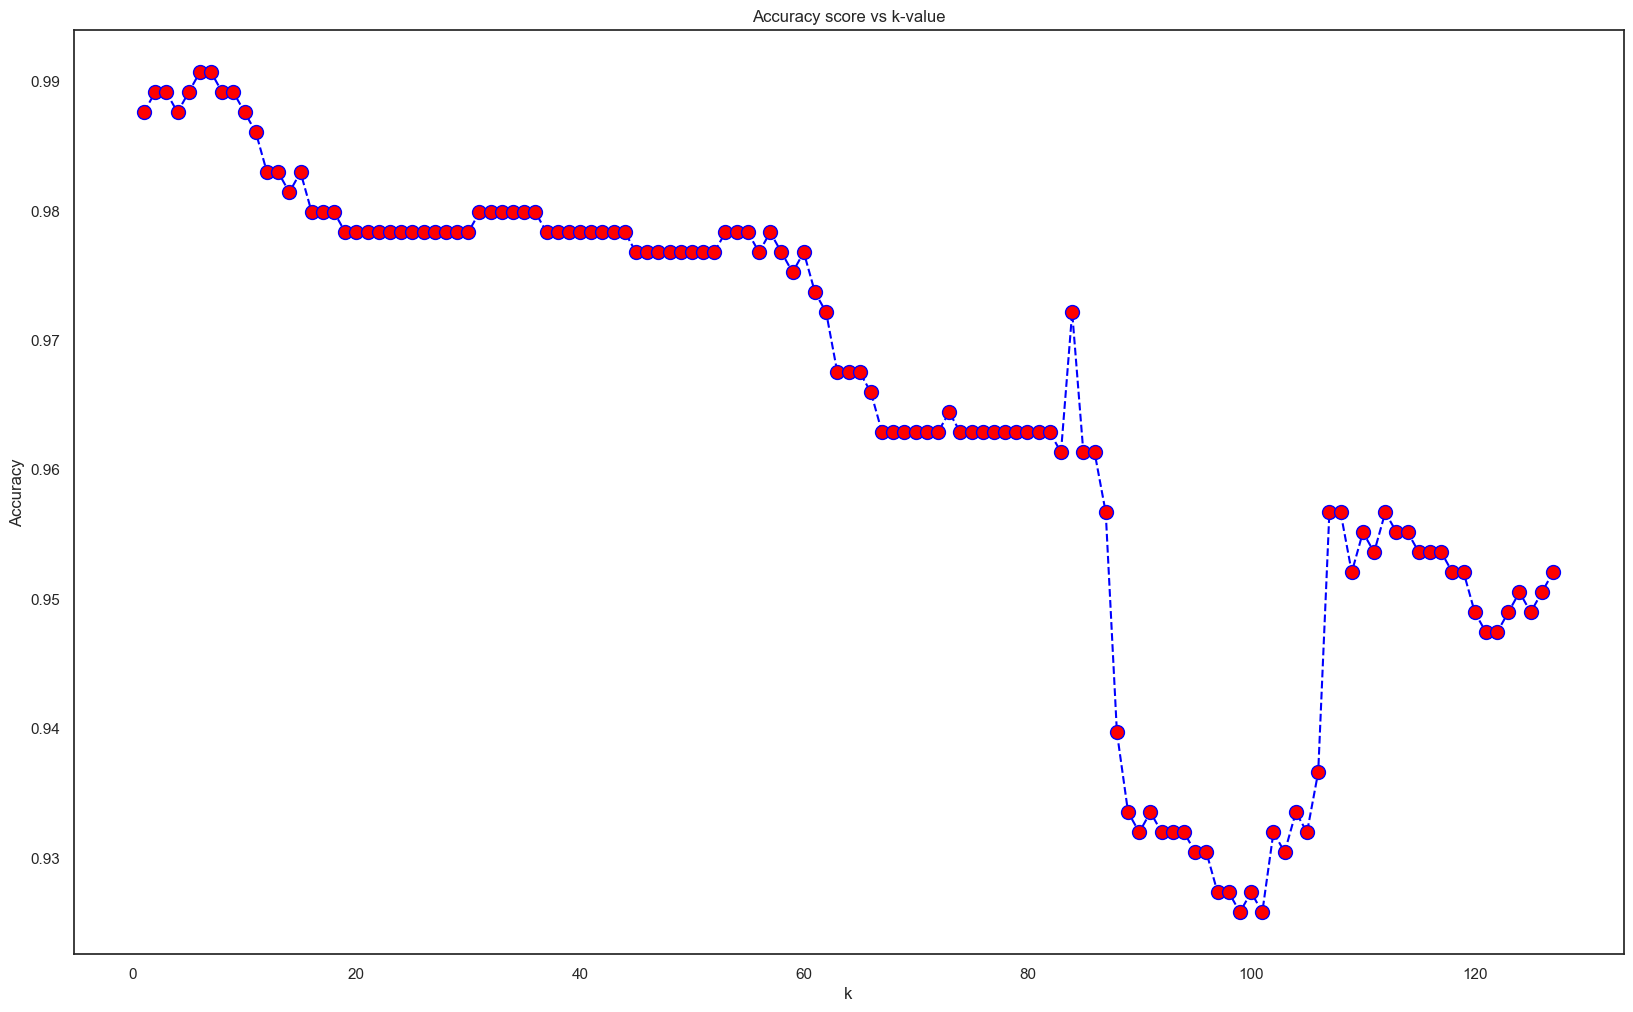

Best accuracy for phase 1: 0.990726429675425, at k=6


In [10]:
plt.plot(range(1, 128), ph1_accuracy_scores, color = "blue",
         linestyle = "dashed",
         marker='o', markerfacecolor="red", markersize=10)

plt.title("Accuracy score vs k-value")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

print(f"Best accuracy for phase 1: {max(ph1_accuracy_scores)}, at k={ph1_accuracy_scores.index(max(ph1_accuracy_scores)) + 1}")

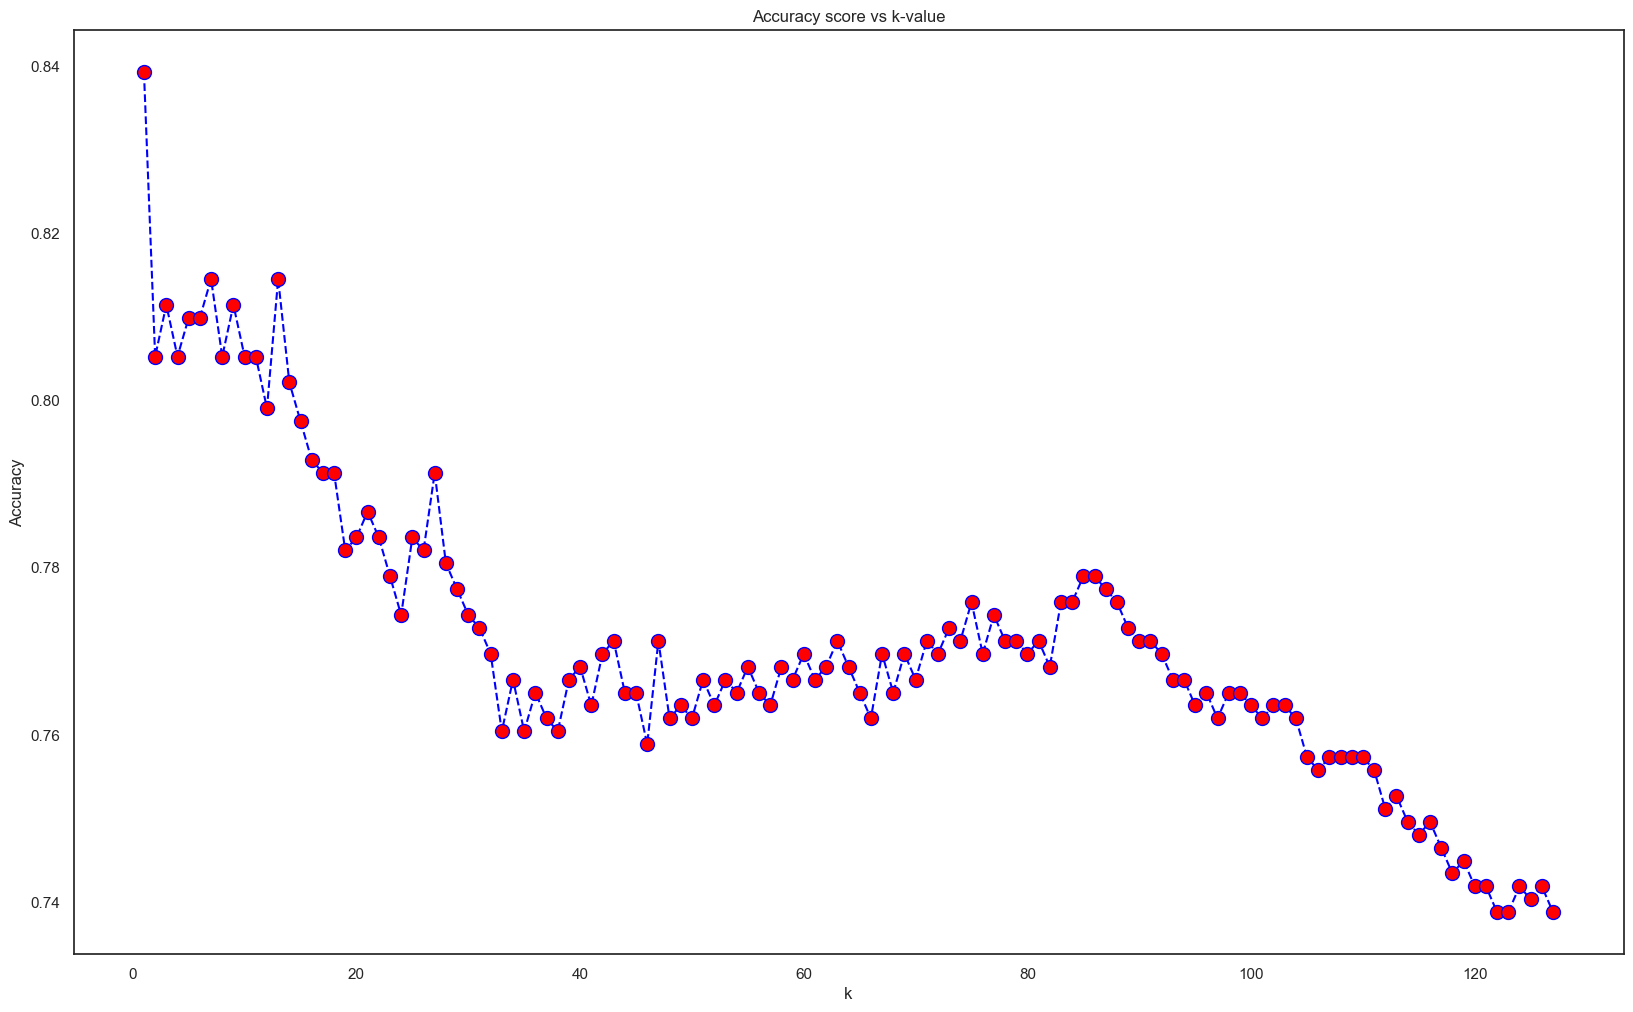

Best accuracy for phase 2: 0.839258114374034, at k=1


In [11]:
plt.plot(range(1, 128), ph2_accuracy_scores, color = "blue",
         linestyle = "dashed",
         marker='o', markerfacecolor="red", markersize=10)

plt.title("Accuracy score vs k-value")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

print(f"Best accuracy for phase 2: {max(ph2_accuracy_scores)}, at k={ph2_accuracy_scores.index(max(ph2_accuracy_scores)) + 1}")

Best accuracy for phase 3: 0.990726429675425, at k=1 and n=10


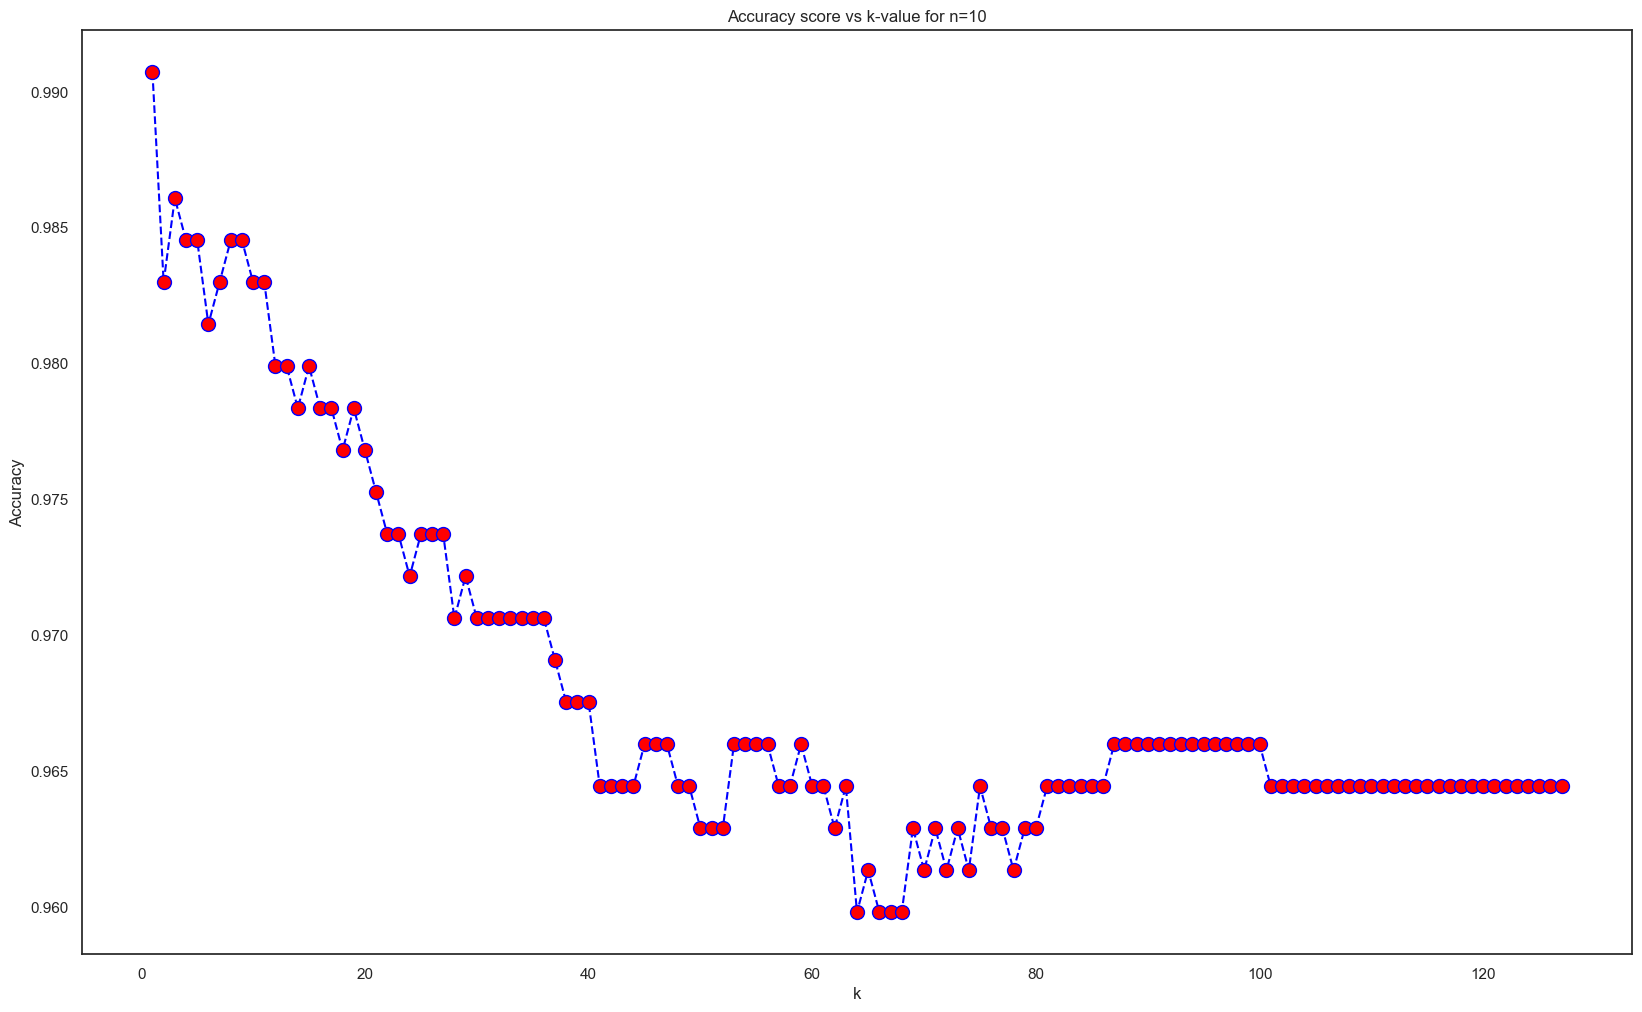

In [12]:
best_k = 0
best_n = 0
max_accuracy_score = 0

for k in range(1,128):
    this_accuracy_scores_for_this_k = cos_pca_accuracy_scores[k-1]

    for index,n in enumerate(n_candidates):
        this_accuracy_score = this_accuracy_scores_for_this_k[index]

        if this_accuracy_score > max_accuracy_score:
            best_k = k
            best_n = n
            best_n_index = index
            max_accuracy_score = this_accuracy_score

print(f"Best accuracy for phase 3: {max_accuracy_score}, at k={best_k} and n={best_n}")

accuracy_scores_for_best_n = []
for k in range(1,128):
    accuracy_scores_for_best_n.append(cos_pca_accuracy_scores[k-1][best_n_index])


plt.plot(range(1, 128), accuracy_scores_for_best_n, color = "blue",
         linestyle = "dashed",
         marker='o', markerfacecolor="red", markersize=10)

plt.title(f"Accuracy score vs k-value for n={best_n}")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()


## Picking and saving a model

In [13]:
best_model = KNeighborsClassifier(n_neighbors = best_k)
best_model.fit(cos_pca_X_train_list[best_n_index], cos_pca_y_train_list[best_n_index])
this_y_pred = best_model.predict(cos_pca_X_test_list[best_n_index])
print(f"The accuracy score for this model is: {accuracy_score(cos_pca_y_test_list[best_n_index], this_y_pred)}")
print(f"The recall score for this model is: {recall_score(cos_pca_y_test_list[best_n_index], this_y_pred)}")
print(f"The precision score for this model is: {precision_score(cos_pca_y_test_list[best_n_index], this_y_pred)}")
print(f"The F1 score for this model is: {f1_score(cos_pca_y_test_list[best_n_index], this_y_pred)}")

best_model_filename = top_dir+f'/models/cos_pca_k{best_k}_n{best_n}.sav'
pickle.dump(best_model, open(best_model_filename, 'wb'))

The accuracy score for this model is: 0.990726429675425
The recall score for this model is: 0.9849397590361446
The precision score for this model is: 0.9969512195121951
The F1 score for this model is: 0.990909090909091
